In [46]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

all_df = pd.read_excel('../TrainDataset2024.xls', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [47]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

In [48]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutliers(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = func(x)
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

removeOutliers(all_df)
# Verify the changes
all_df.head()

# Assign features to X
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

1. Feature 11 (0.136179)
2. Feature 12 (0.125406)
3. Feature 13 (0.117083)
4. Feature 10 (0.116910)
5. Feature 0 (0.116168)
6. Feature 9 (0.112624)
7. Feature 8 (0.111027)
8. Feature 7 (0.034109)
9. Feature 4 (0.032189)
10. Feature 1 (0.029491)
11. Feature 6 (0.026875)
12. Feature 2 (0.017385)
13. Feature 3 (0.015089)
14. Feature 5 (0.009464)


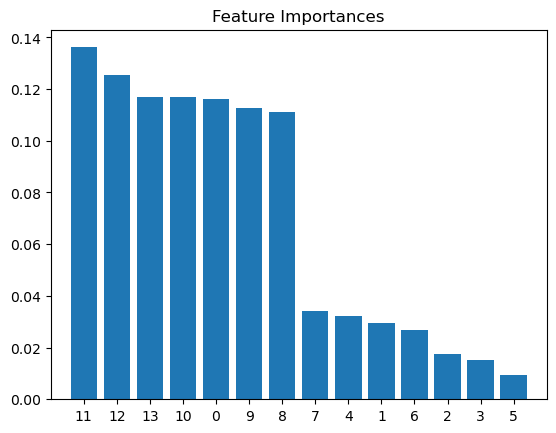

' \n# Apply LDA to all except required features\nlda = LinearDiscriminantAnalysis(n_components=1)\nXs_lda = lda.fit_transform(Xs_selected, clf_y)\n\n# Combine required features with LDA transformed features\nXs = np.hstack((required_features, Xs_lda)) '

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Normalise the features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [1,3,10]
required_features = Xs[:, mandatory_features_indices]

# Manifold Learning
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt 

X_non_required = np.delete(Xs, mandatory_features_indices, axis=1)

X_mri = X_non_required[:, 11:]
X_non_mri = X_non_required[:, :11]
tsne = TSNE(n_components=3, random_state=42) 
X_mri_tsne = tsne.fit_transform(X_mri)

# join non mri woth x_tsne
Xs_tsne = np.c_[X_non_mri, X_mri_tsne]

rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rnd_clf.fit(Xs_tsne, clf_y)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(Xs_tsne.shape[1]):
    print("%d. Feature %d (%f)" % (i + 1, indices[i], importances[indices[i]]))

plt.title('Feature Importances')
plt.bar(range(Xs_tsne.shape[1]), importances[indices], align='center')
plt.xticks(range(Xs_tsne.shape[1]), indices)
plt.xlim([-1, Xs_tsne.shape[1]])
plt.show()

Xs_selected = Xs_tsne[:, indices[:8]]
Xs = np.hstack((required_features, Xs_selected))

""" 
# Apply LDA to all except required features
lda = LinearDiscriminantAnalysis(n_components=1)
Xs_lda = lda.fit_transform(Xs_selected, clf_y)

# Combine required features with LDA transformed features
Xs = np.hstack((required_features, Xs_lda)) """

In [51]:
from numpy import mean, std
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=1)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
from sklearn.linear_model import LogisticRegression

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = LogisticRegression(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
from sklearn.model_selection import train_test_split

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, clf_y, test_size=0.3,
random_state=1, stratify=clf_y)

from sklearn.svm import SVC

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = SVC(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.01, 0.1]
space['kernel'] = ["rbf", "linear", "poly"]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs_train, y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs_train, y_train)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

from sklearn.metrics import accuracy_score

classifier_score = best_model.score(Xs_test, y_test)
print('The classifier accuracy score is {:03.2f}'.format(classifier_score))

Accuracy: 0.789 (0.063)
Best Model: SVC(C=10, gamma=0.01, kernel='poly', random_state=1)
The classifier accuracy score is 0.79


1. Feature 13 (0.101257)
2. Feature 11 (0.099207)
3. Feature 14 (0.092318)
4. Feature 16 (0.091743)
5. Feature 15 (0.088080)
6. Feature 12 (0.083805)
7. Feature 9 (0.083795)
8. Feature 0 (0.081628)
9. Feature 10 (0.080925)
10. Feature 8 (0.076676)
11. Feature 4 (0.026629)
12. Feature 1 (0.025701)
13. Feature 7 (0.022663)
14. Feature 6 (0.018714)
15. Feature 2 (0.011471)
16. Feature 3 (0.009455)
17. Feature 5 (0.005935)


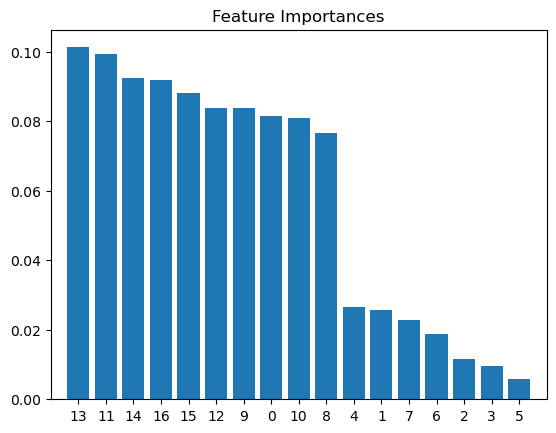

' \n# Apply LDA to all except required features\nlda = LinearDiscriminantAnalysis(n_components=1)\nXs_lda = lda.fit_transform(Xs_selected, clf_y)\n\n# Combine required features with LDA transformed features\nXs = np.hstack((required_features, Xs_lda)) '

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Normalise the features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [1,3,10]
required_features = Xs[:, mandatory_features_indices]

# Manifold Learning
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt 

X_non_required = np.delete(Xs, mandatory_features_indices, axis=1)

X_mri = X_non_required[:, 11:]
X_non_mri = X_non_required[:, :11]
tsne = PCA(n_components=6, random_state=1) 
X_mri_tsne = tsne.fit_transform(X_mri)

# join non mri woth x_tsne
Xs_tsne = np.c_[X_non_mri, X_mri_tsne]

rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=1, n_jobs=-1)
rnd_clf.fit(Xs_tsne, clf_y)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(Xs_tsne.shape[1]):
    print("%d. Feature %d (%f)" % (i + 1, indices[i], importances[indices[i]]))

plt.title('Feature Importances')
plt.bar(range(Xs_tsne.shape[1]), importances[indices], align='center')
plt.xticks(range(Xs_tsne.shape[1]), indices)
plt.xlim([-1, Xs_tsne.shape[1]])
plt.show()

Xs_selected = Xs_tsne[:, indices[:10]]
Xs = np.hstack((required_features, Xs_selected))

""" 
# Apply LDA to all except required features
lda = LinearDiscriminantAnalysis(n_components=1)
Xs_lda = lda.fit_transform(Xs_selected, clf_y)

# Combine required features with LDA transformed features
Xs = np.hstack((required_features, Xs_lda)) """

In [ ]:
from sklearn.model_selection import train_test_split

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, clf_y, test_size=0.3,
random_state=1, stratify=clf_y)

from sklearn.svm import SVC

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = SVC(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10]
space['gamma'] = [0.01, 0.1]
space['kernel'] = ["rbf", "linear",]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

from sklearn.metrics import accuracy_score

classifier_score = best_model.score(Xs_test, y_test)
print('The classifier accuracy score is {:03.2f}'.format(classifier_score))

Accuracy: 0.785 (0.048)
Best Model: SVC(C=0.1, gamma=0.01, random_state=1)
The classifier accuracy score is 0.79


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=16, metric='manhattan', weights='uniform')
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(knn, Xs, clf_y, cv=kfold, scoring='accuracy')
print("LDA cross validation scores:", cv_scores)
print("LDA mean accuracy:", cv_scores.mean())
print("LDA standard deviation score:", cv_scores.std())

LDA cross validation scores: [0.8   0.8   0.775 0.775 0.8  ]
LDA mean accuracy: 0.79
LDA standard deviation score: 0.012247448713915901


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_pCR = MLPClassifier(random_state=1, max_iter=1000)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_pCR = cross_val_score(mlp_pCR, Xs, clf_y, cv=kfold, scoring='balanced_accuracy')
print(f'Balanced Accuracy for PCR (cross-validated): {cv_scores_pCR.mean()} ± {cv_scores_pCR.std()}')

/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Balanced Accuracy for PCR (cross-validated): 0.5945284498207886 ± 0.0273594183419313
